In [1]:
# Imports
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial import distance_matrix, distance

## MetroMap Implementation

Repository: https://github.com/filipLoisel/SOS/tree/main/UE3/src

This implementation of the MetroMap visualisation includes the features: (1.) showing discretized component plane lines, (2.) selecting the most informative component lines based on the number of connected regions, (3.) aggregating similar component lines based on a threshold given using wards clustering, and (4.) snapping lines to close points. Furthermore, the user can provide a list of names for the components which will be labeled. If no list is given, our implementation will auto-create labels for the component lines (e.g., Component 0, Component 1, etc.). Aggregated lines will be named by combining the individual names. The visualisation also shows the high and low endpoint for each line. If aggregation is used, these points are only shown if no reversed distance was used during the aggregation. The main concept of this visualisation were taken from [1]. The U-Matrix implementation is taken from [2].

Moreover, the implementation provides three parameters:
1. Number of bins for discretization
2. Threshold for aggregation
3. Number of selected lines
4. Background visualisation: Can be used as underlying visualisation for the Metro Map. If no visualisation is provided, the U-Matrix will be used.

To see the effect and influence of these different parameters, and how to run the visualisation, please take a look at the end of the notebook (Section Bin Size).

### 1. Read computed SOM

In [2]:
from SOMToolBoxParser import SOMToolBoxParser

input_vectors = SOMToolBoxParser("datasets/chainlink/chainlink.vec").read_weight_file()
weight_vectors = SOMToolBoxParser("datasets/chainlink/chainlink_small.wgt.gz").read_weight_file()

### 2.a Component Planes

For each unit, take the weight vector of the corresponding attribute

In [3]:
def make_component_planes(vectors):
    return np.array([vectors['arr'][:, i] for i in range(vectors['vec_dim'])]).reshape((
        vectors['vec_dim'], vectors['ydim'], vectors['xdim']))

### 2.b Discretization

Input parameter `n`: number of bins

<AxesSubplot:>

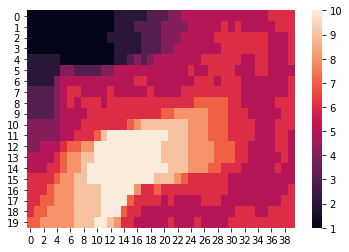

In [4]:
def discretize_planes(vectors, n=10):
    component_planes = make_component_planes(vectors)
    discretized_planes = []
    for component_plane in component_planes:
        bins = np.linspace(component_plane.min(), component_plane.max(), n, False)
        discretized_plane = np.digitize(component_plane, bins)
        discretized_planes.append(discretized_plane)
        
    return discretized_planes

sns.heatmap(discretize_planes(weight_vectors, n=10)[0])

### 3. Component Lines (Fi)

After performing the discretisation of the component planes, we have `n` disjoint ranges for each component. To visualize the component lines, we calculate the gravity center of the individual regions, resulting in `n` region center that we connect to a line for each component. Calculating the centers is described in the paper by Neumayer et al. [1]:

1. For each component, take a region
2. Get the region limits and calculate the set of units that fall within these intervals
3. Calculate the gravity center by summing up all discretised values of the set and dividing by the set's cardinality
4. Repeat 1-3 until all regions of all components are covered

`get_component_lines`: takes as input the discretised planes `binned_planes`, the number of bins `n`, and an optional list of component names for labeling `component_names`. Returns a tuple, where the first element is a 2d array (lines for each component), and `component_names` if specified. Otherwise, the second tuple element is an array of auto-generated component names (`Component 0`, `Component 1`, ...).

In [5]:
def calculate_region_center(points):
    return sum(points) / len(points)


def get_points_inside_region(region, component):
    return np.argwhere(component == region)


def get_region_centers(component, n):
    region_centers = []
    for region_index in range(n):
        region = region_index + 1
        included_points = get_points_inside_region(region, component)
        region_center = calculate_region_center(included_points)
        region_centers.append(region_center)
    return region_centers


def get_component_lines(binned_planes, n, component_names = []):
    lines = []
    name_list = component_names.copy()

    is_empty = False
    if not name_list:
        is_empty = True
        
    for i, component in enumerate(binned_planes):
        region_centers = get_region_centers(component, n)
        lines.append(region_centers)
        if is_empty:
            name_list.append('Component ' + str(i))

    return np.array(lines), np.array(name_list)

lines, names = get_component_lines(discretize_planes(weight_vectors, n=10), n=10)

## Metro Map Visualization

### 4. Visualization

Connect the centers with lines

### U - Matrix

In [6]:
def umatrix(_m, _n, _weights):
    um =np.zeros((_m *_n, 1))
    neuron_locs = list()
    for i in range(_m):
        for j in range(_n):
            neuron_locs.append(np.array([i, j]))
    neuron_distmat = distance_matrix(neuron_locs,neuron_locs)

    for i in range(_m * _n):
        neighbor_idxs = neuron_distmat[i] <= 1
        neighbor_weights = _weights[neighbor_idxs]
        um[i] = distance_matrix(np.expand_dims(_weights[i], 0), neighbor_weights).mean()

    return um.reshape(_m,_n)

(20, 40)

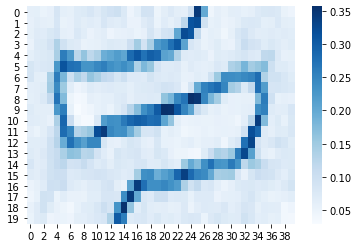

In [7]:
u_matrix = umatrix(weight_vectors['ydim'], weight_vectors['xdim'], weight_vectors['arr'])
sns.heatmap(u_matrix, cmap="Blues")
u_matrix.shape

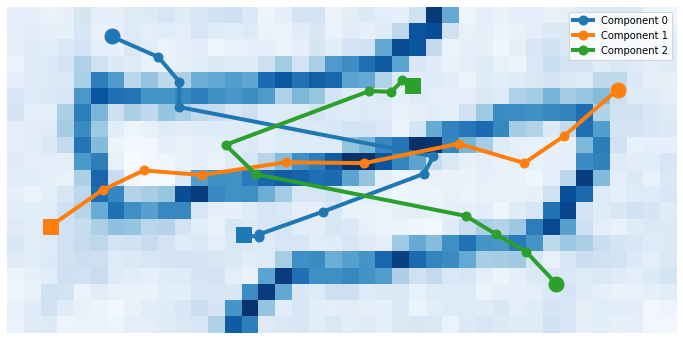

In [8]:
def visualize(lines, u_matrix, reverse_used = False, _vmin=None,_vmax=None, scale=12, component_names = [], ):
    colors = iter(mcolors.TABLEAU_COLORS)
    
    if not reverse_used:
        reverse_used = [False]*lines.shape[0] # false means no reverse
       
    plt.figure(figsize=(scale*u_matrix.shape[1]/u_matrix.shape[1],scale*u_matrix.shape[0]/u_matrix.shape[1]))
    sns.heatmap(u_matrix, cmap="Blues", vmin = _vmin, vmax = _vmax, cbar=False, xticklabels = False, yticklabels = False)
    for i, line in enumerate(lines):
        color = next(colors)
            
        x_coordinates = [point[0] for point in line]
        y_coordinates = [point[1] for point in line]
        plt.plot(y_coordinates, x_coordinates, '-o', linewidth=4, markersize = 9,color=color, label=component_names[i])
        
        if not reverse_used[i]:
            plt.plot(y_coordinates[0], x_coordinates[0], '-o', markersize = 15, color=color)
            plt.plot(y_coordinates[-1], x_coordinates[-1], '-s', markersize = 15, color=color)
    plt.legend()
    plt.show()

visualize(lines, u_matrix, component_names=names)

### 5. Aggregation (FL)

Creates distance matrix by calculating each parwise distance. The distance metric is given in the paper "Component Selection for the Metro Visualisation of the Self-Organising Map". Ward's clustering is aplied with the given threshold.

To aggregate simply call aggregate()

which gets passed:

    *lines* array, array of all lines order must match up with names
    *threshold* float or int, threshold for the wards clustering
    *names* array, array of names order must match up with lines
    *print_z* bool.  Whether the Z matrix should be printed (usefull for figuring out a sensible threshold value)
    
and returns:  

    *final_lines* array, the aggregated lines. May not have the same order as before, however order is consitent with final names and , reverse list.
    *final_names* array, The aggregated names.
    *reverse_list* array, list indicating for each cluster whether or not it a line was reversed in the aggregation process (use full for visualizing high and low points) 



[[  1.           2.         108.63113616   2.        ]
 [  0.           3.         130.51657031   3.        ]]
['Component 1 + Component 2', 'Component 0']
[False, False]


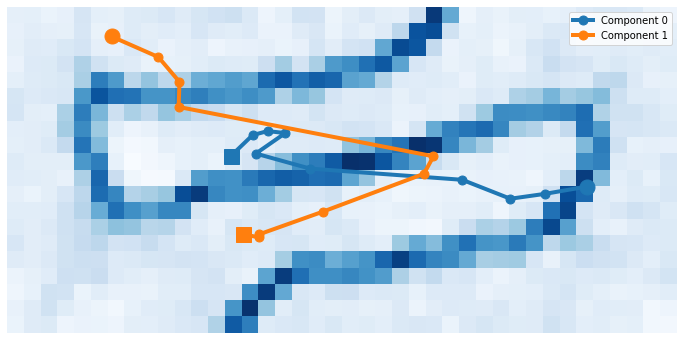

In [9]:
def distance(l1, l2):
    """
    Returns:
    float, the distance of two lines, 
    int, whether it's the normal or the reverse distance
    
    distance metric from the paper 
    "Component Selection for the Metro Visualisation of the Self-Organising Map"
    """
    distance_normal = 0
    distance_reversed = 0
    for i in range(len(l1)):
        distance_normal += np.linalg.norm(l1[i] - l2[i])
        distance_reversed += np.linalg.norm(l1[i] - l2[-(i + 1)])
    l = [distance_normal, distance_reversed]
    return min(l), np.where(l == min(l))[0][0]  # [0][0] to get an int instead of an array


def create_distance_matrix(lines):
    """
    returns:
        array, a distance matrix with the pairwise distance of each line
        array, a matrix indicating whether the distance between the lines is reversed or not
    """
    n_lines = lines.shape[0]
    matrix = np.empty((n_lines, n_lines))
    normal_or_not = np.empty((n_lines, n_lines))
    for i in range(n_lines):
        for j in range(n_lines):
            if i == j:
                matrix[i, j] = np.inf
                normal_or_not[i, j] = -1
            else:
                matrix[i, j] = distance(lines[i], lines[j])[0]
                normal_or_not[i, j] = distance(lines[i], lines[j])[1]

    return np.triu(matrix, 1), normal_or_not


def assign_clusters(d_matrix, threshold, print_Z=False):
    """
    does wards clustering with the given distance matrix and threshold
    returns 
    array, array indicating which cluster each line is assigned to.
    """
    Z = ward(d_matrix[d_matrix > 0])
    # see link for explanation of Z
    # https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster
    if print_Z:
        print(Z)
    assigned_clusters = fcluster(Z, threshold, criterion='distance')
    return assigned_clusters


def average_lines(lines, clusters, r_matrix, names):
    ''' 
    averages x,y values of all lines per cluster, concatenates names of clustered lines,
    returns
        array, averaged lines
        array, concatenated names
        array, array indicates for each cluster whether a reverse distance was used.
    
    '''

    reverse_list = []
    final_lines = []
    final_names = []
    for i in range(max(clusters)):  # iterate trough clusters
        reverse_used = False #indicates if the cluster contains a reversed line
        cluster_lines = np.where(clusters == i + 1)
        if len(cluster_lines[0]) == 1:
            final_lines.append(lines[cluster_lines[0]][0].tolist())
            final_names.append(names[cluster_lines[0][0]])
            reverse_list.append(reverse_used)
            continue

        first_ind = cluster_lines[0][0]
        name = names[first_ind]
        averaged_line = lines[first_ind]
        for compare_ind in cluster_lines[0]:  # itearate trough lines
            if r_matrix[first_ind, compare_ind] == 0:  # normal distance
                averaged_line = averaged_line + lines[compare_ind]
                name += " + " + names[compare_ind]

            elif r_matrix[first_ind, compare_ind] == 1:  # reverse distance
                name += " + " + names[compare_ind]
                reverse_used = True
                averaged_line = averaged_line + np.flip(lines[compare_ind], axis=0)
        averaged_line = (averaged_line / len(cluster_lines[0])).tolist()
        reverse_list.append(reverse_used)
        final_lines.append(averaged_line)
        final_names.append(name)

    return final_lines, final_names, reverse_list


def aggregate(lines, threshold, names, print_Z=False):
    """
    calls all the right funcitons and returns the result. (see above for parameters/return objects)
    """
    d_matrix, r_matrix = create_distance_matrix(lines)
    clusters = assign_clusters(d_matrix, threshold, print_Z)
    new_lines, names, reverse_list = average_lines(lines, clusters, r_matrix, names)
    new_lines = np.array(new_lines)
    return new_lines, names, reverse_list


agg_lines, agg_names, reverse_list = aggregate(lines,110,names,True)
print(agg_names)
print(reverse_list)
visualize(agg_lines, u_matrix,reverse_used = reverse_list, component_names=names)

### 6. Selection

See Algorithm 1 (NEU07_wsom paper)
select only components with a small amount of regions per bin


In [10]:
def select_components(d_planes, component_names,n = 5):

    assert n <= len(d_planes), "Selection size must be smaller or equal to number of components!"

    def valid_neighbor(row, col):

            #getting dimensions
            rows = len(d_planes[0])
            cols = len(d_planes[0][0])

            return 0 <= row < rows and 0 <= col < cols

    def get_neighbors(row, col):
            for drow, dcol in [(0, 1), (0, -1), (1, 0), (-1, 0)]: #, (-1, 1), (-1, -1), (1, -1), (1, 1)]:
                nrow, ncol = row+drow, col+dcol
                if valid_neighbor(nrow, ncol):
                    yield nrow, ncol

    def get_regions_per_component(d_planes):

        #getting dimensions
        rows = len(d_planes[0])
        cols = len(d_planes[0][0])

        regions_per_component = []

        for component_plane in d_planes:
            n = component_plane.max()



            number_of_regions = 0
            for bin_value in range(1,n+1):
                regions = {}

                assigned_units = component_plane*0
                current_region_number = 1

                for row in range(len(component_plane)):
                    for col in range(len(component_plane[row])):
                        #check if unit is already assigned
                        if assigned_units[row][col] == 0 and component_plane[row][col]==bin_value:


                            assigned_neighbours = 0


                            for nrow, ncol in get_neighbors(row,col):

                                previous_assignment = assigned_units[row][col]



                                if assigned_units[nrow][ncol] != 0 and component_plane[row][col] == component_plane[nrow][ncol]:


                                    #add to neighbors region

                                    regions[assigned_units[nrow][ncol]].append((row,col))
                                    assigned_units[row][col] = assigned_units[nrow][ncol]

                                    assigned_neighbours += 1


                                    if assigned_neighbours > 1 and assigned_units[nrow][ncol] != previous_assignment:


                                        #merge
                                        regions[assigned_units[nrow][ncol]] = regions[assigned_units[nrow][ncol]] + regions[previous_assignment]

                                        #update assignment in assigned units 
                                        for tup in regions[previous_assignment]:
                                            r = tup[0]
                                            c = tup[1]
                                            assigned_units[r][c] = assigned_units[nrow][ncol]


                                        del regions[previous_assignment]





                            if assigned_neighbours == 0:



                                regions[current_region_number] = [(row,col)]
                                assigned_units[row][col] = current_region_number
                                current_region_number += 1

                # add the region count for this bin to the total           
                number_of_regions += len(regions)

            # adding the total for each component to the list  
            regions_per_component.append(number_of_regions)


        return regions_per_component
    output = []
    output_names = []
    region_count = get_regions_per_component(d_planes)
        
    ind_l = list(range(len(region_count)))
    ind_l = [ind for _, ind in sorted(zip(region_count, ind_l))]
    
    for i in ind_l[:n]:
        output.append(d_planes[i])
        output_names.append(component_names[i])

    return np.array(output)


### 7. Snapping

See Algorithm 1 (https://github.com/yozoon/SOM-MetroMap/blob/main/implementation_report.pdf)

See implementation of template method `_find_snapped_line`



In [11]:
def snap_component_lines(component_lines, d_planes):
    step=1

    rows = len(d_planes[0])
    cols = len(d_planes[0][0])


    def valid_neighbor(row, col):
        return 0 <= row < rows and 0 <= col < cols

    def get_snapping_anchors(point, dist, step):
        for di in range(0,dist,step):
            for drow, dcol in [(0, 1 + di), (0, -1 - di), (1 + di, 0), (-1 - di, 0), (-1-di, 1+di), (-1-di, -1-di), (1+di, -1-di), (1+di, 1+di)]:
                        nrow, ncol = point[0]+drow, point[1]+dcol
                        if valid_neighbor(nrow,ncol):
                            yield [nrow, ncol]


    def snap_points(line, step):
        line[0] = [round(line[0][0]), round(line[0][1])]
        for i in range(len(line)-1):
            dist = round(np.linalg.norm(line[i] - line[i+1]))+1
            nearest_anchor = 0
            nearest_anchor_dist = float('inf')
            for anchor in get_snapping_anchors(line[i], dist, step):
                distance_to_anchor = np.linalg.norm(line[i+1] - anchor)
                if distance_to_anchor < nearest_anchor_dist:
                    nearest_anchor_dist = distance_to_anchor
                    nearest_anchor = anchor

            line[i+1] = nearest_anchor

        return line

    snapped_lines = []
    
    for c_line in component_lines:
        snapped_lines.append(snap_points(c_line, step))

    return np.array(snapped_lines)

## Metro Map Test

To run the MetroMap visualisation, execute `metro_maps` with the following parameters:
- `weights`: pretrained weight vectors of the SOM
- `n_bins`: Number of bins for Discretization
- `threshold`: Threshold for aggregation
- `n_select`: Number of selected lines
- `background_vis`: Background visualisation: Can be used as underlying visualisation for the Metro Map. If no visualisation is provided, the U-Matrix will be used.
- `scale`: Set figure size
- `names`: Provide a list of component names. If empty, auto-generated names
- `print_Z`: Z-Matrix produced by wards clustering, listing threshold values.
- `select`: Use selection
- `agg`: Use aggregation
- `snap`: Use snapping
- `_vmin`: lower bound for the colormap (U-Matrix)
- `_vmax`: upper bound for the colormap (U-Matrix)

In [12]:
chain_weight = SOMToolBoxParser("datasets/chainlink/chainlink_small.wgt.gz").read_weight_file()
clusters_weight = SOMToolBoxParser("datasets/10clusters/10clusters_large.wgt.gz").read_weight_file()

In [13]:
def metro_maps(weights,n_bins=7,n_select=2,threshold=78,scale=10,names=[],print_Z=False,select=True,agg=True,snap=True,background_vis=None, _vmin=None,_vmax=None):
    cluster_planes = discretize_planes(weights, n = n_bins)
    if background_vis is None:
        background_vis = umatrix(weights['ydim'], weights['xdim'], weights['arr'])
    lines_to_plot, names = get_component_lines(cluster_planes, n = n_bins,component_names=names)
    reverse_used=False

    # select
    if select:
        lines_to_plot, names = get_component_lines(select_components(cluster_planes,n = n_select, component_names = names), n = n_bins)

    # aggregate
    if agg:
        lines_to_plot, names, reverse_used = aggregate(lines_to_plot,threshold, print_Z=print_Z,names=names)

    # snap
    if snap:
        lines_to_plot = snap_component_lines(lines_to_plot, cluster_planes)

    visualize(lines_to_plot, background_vis, reverse_used,scale=scale, component_names = names, _vmin=_vmin,_vmax=_vmax)

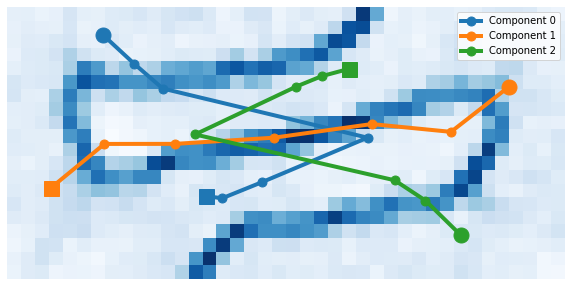

In [14]:
metro_maps(chain_weight, agg=False, select=False, snap=False)

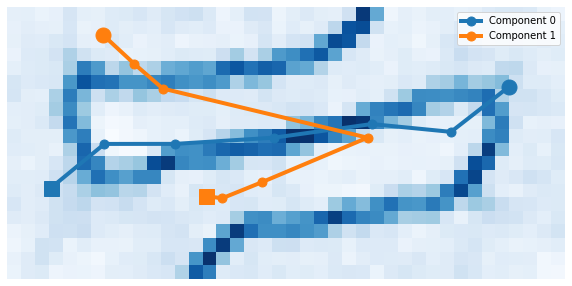

In [15]:
metro_maps(chain_weight, n_select=2, select=True, agg=False, snap=False)

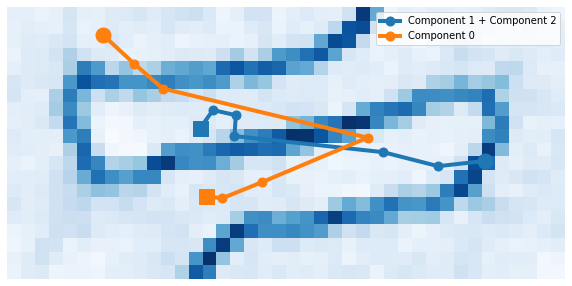

In [16]:
metro_maps(chain_weight, select=False, agg=True, snap=False)

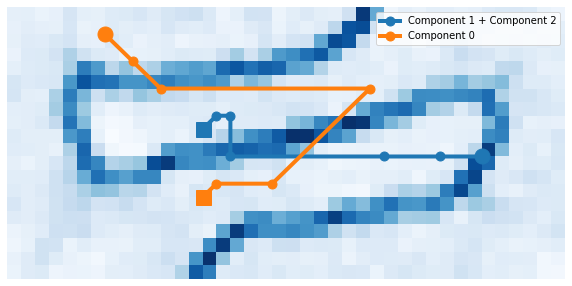

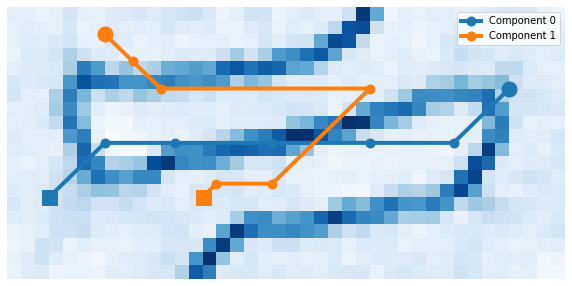

In [17]:
metro_maps(chain_weight, n_select=2, select=False, agg=True, snap=True)
metro_maps(chain_weight, n_select=2, select=True, agg=False, snap=True)

## Bin Size

Small values of the parameter `n_bins` which represent the number of bins per component, do not reveal informative structures of the underlying data set. While very large values result in lots of noise. Reducing the number of bins to a reasonable value, can show more useful information about the SOM.

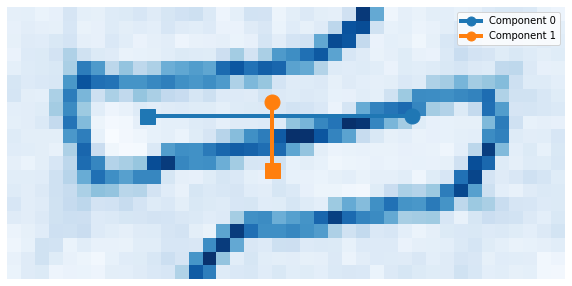

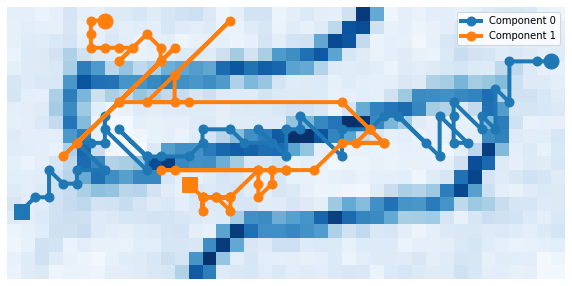

In [18]:
metro_maps(chain_weight, n_select=2, select=True, agg=False, snap=True, n_bins=2)
metro_maps(chain_weight, n_select=2, select=True, agg=False, snap=True, n_bins=50)

## Thresholds

The parameter performs as expected: No aggregation can be observed when very low values are used. On the other hand, setting the threshold very high will result in every line will be aggregated into one single line.

Using a high threshold, lines with high distances as defined in the paper will also be aggregated, while a smaller threshold aggregates similar lines.

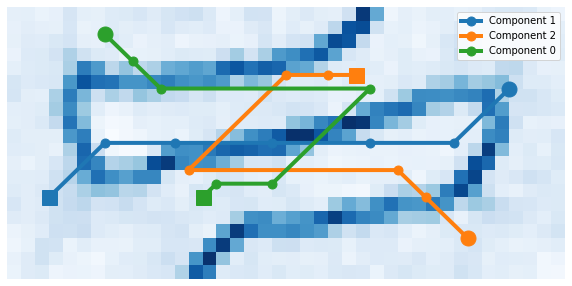

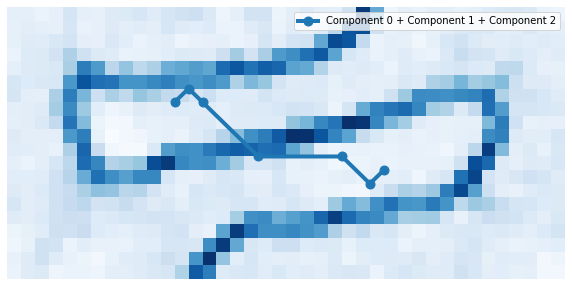

In [19]:
metro_maps(chain_weight, threshold=0, select=False, agg=True, snap=True)
metro_maps(chain_weight, threshold=1000, select=False, agg=True, snap=True)

## Number of Selected Lines

This parameter is responsible for selecting the lines with the lowest amount of regions per bins. As the reader can see, `n_select` does indeed filter the correct number (`n`) of lines.

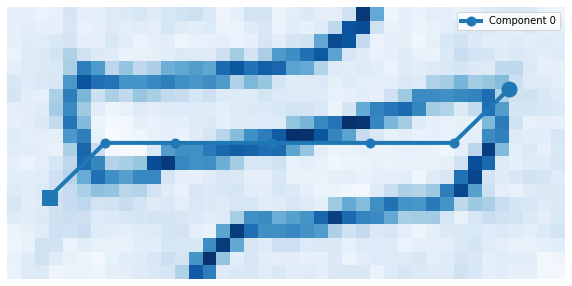

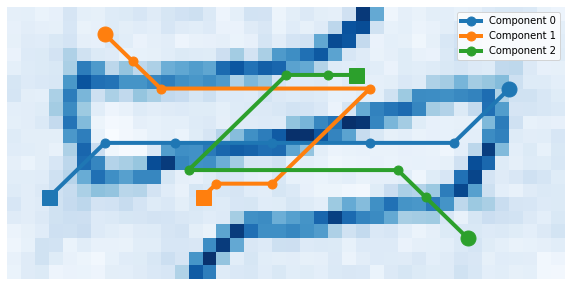

In [20]:
metro_maps(chain_weight, n_select=1, select=True, agg=False, snap=True)
metro_maps(chain_weight, n_select=3, select=True, agg=False, snap=True)

The next graph shows all functionalities of our implementation on the pretrained small 10clusters SOM, activated sequentially. Through aggregation, selection, and snapping, much more informative visualisations can be produced.

We also used the parameter `print_Z` to find suitable threshold values for the aggregation.

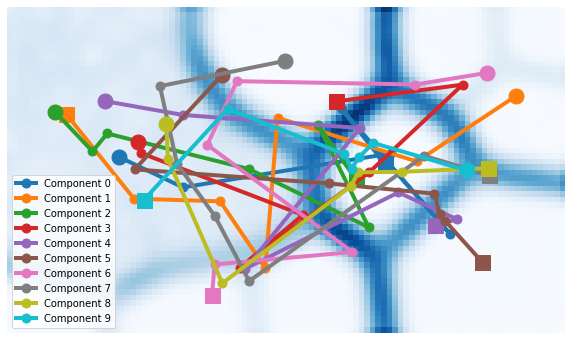

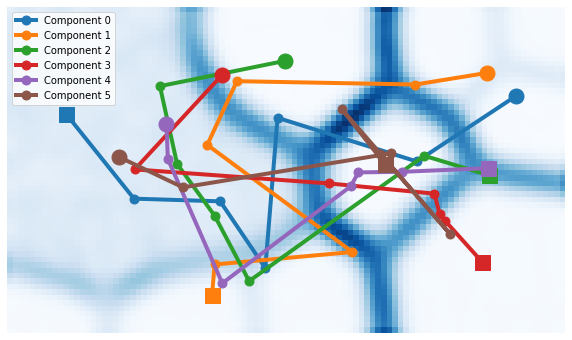

[[  0.           4.          99.24068178   2.        ]
 [  3.           5.         114.60013169   2.        ]
 [  2.           6.         134.61559225   3.        ]
 [  1.           8.         190.34650077   4.        ]
 [  7.           9.         212.4108245    6.        ]]


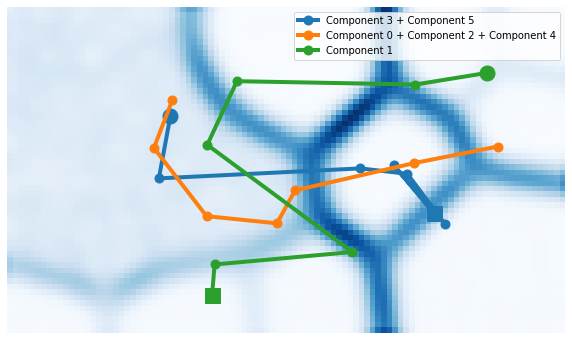

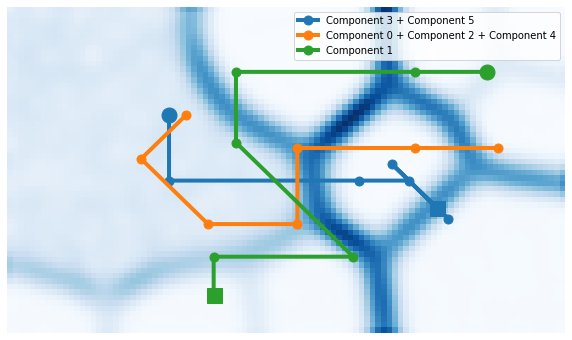

In [21]:
metro_maps(clusters_weight, select=False, agg=False, snap=False)
metro_maps(clusters_weight, n_select=6, select=True, agg=False, snap=False)
metro_maps(clusters_weight, n_select=6, threshold=138, print_Z=True, select=True, agg=True, snap=False)
metro_maps(clusters_weight, n_select=6, threshold=138, select=True, agg=True, snap=True)

[[ 3.          4.          0.39623543  2.        ]
 [ 2.          5.         15.33861125  2.        ]
 [ 0.          6.         17.86396317  3.        ]
 [ 7.          8.         28.14473632  5.        ]
 [ 1.          9.         36.29425642  6.        ]]


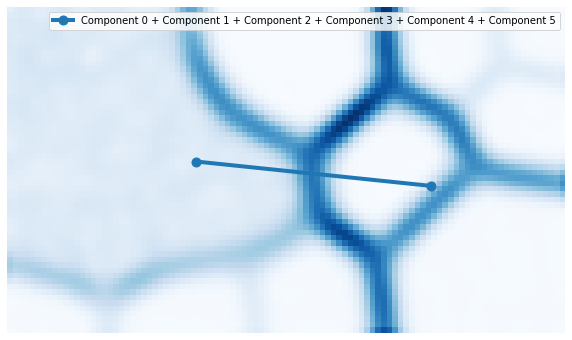

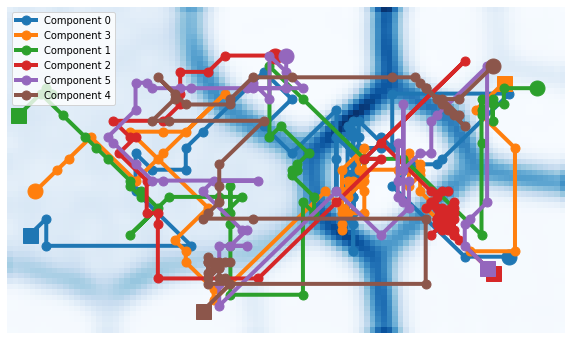

In [22]:
metro_maps(clusters_weight, n_select=6, threshold=138, print_Z=True, select=True, agg=True, snap=False, n_bins=2)
metro_maps(clusters_weight, n_select=6, threshold=138, select=True, agg=True, snap=True, n_bins=50)

# Comparison

In this section, we compare our implementation with the MetroMap visualisation of the Java SOM Toolbox. The first difference we noticed is that the Java implementation does not support aggregation and selection and the same time, while our implementation provides selection, and then aggregation in one run. Both implementation support snapping at the end.

We perform the comparison with the pretrained 10clusters and chainlink SOM. The number of bins is set to 6.

## 10Clusters

![10Clusters small with aggregation](Images/10cluster_small_agg.png)

![10Clusters small with aggregation](Images/10clusters_large_sel.png)

[[ 8.          9.         19.51680464  2.        ]
 [ 1.          4.         27.4556898   2.        ]
 [ 0.         10.         28.72726792  3.        ]
 [11.         12.         37.99946129  5.        ]
 [ 3.          7.         38.13601558  2.        ]
 [ 2.         14.         47.14199437  3.        ]
 [ 5.         13.         49.43274315  6.        ]
 [15.         16.         72.64778057  9.        ]
 [ 6.         17.         76.37566988 10.        ]]


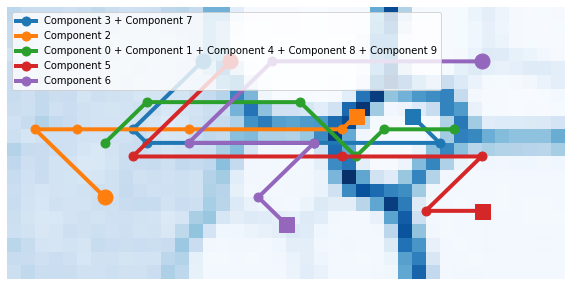

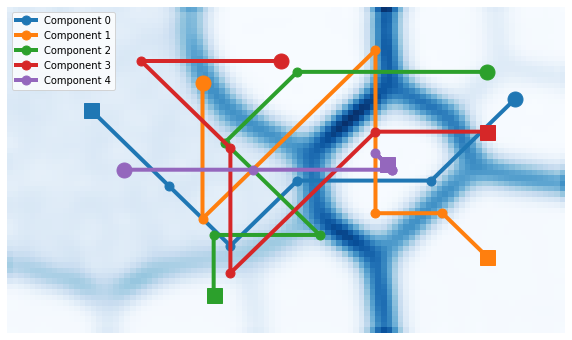

In [23]:
weights = SOMToolBoxParser("datasets/10clusters/10clusters_small.wgt.gz").read_weight_file()
metro_maps(weights, threshold=40, print_Z=True, select=False, agg=True, snap=True, n_bins=6)

weights = SOMToolBoxParser("datasets/10clusters/10clusters_large.wgt.gz").read_weight_file()
metro_maps(weights, threshold=40, n_select=5, select=True, agg=False, snap=True, n_bins=6)

## Chainlink

![Chainlink](Images/chinlink_small_snapped.png)

![Chainlink](Images/chainling_large_snapped.png)

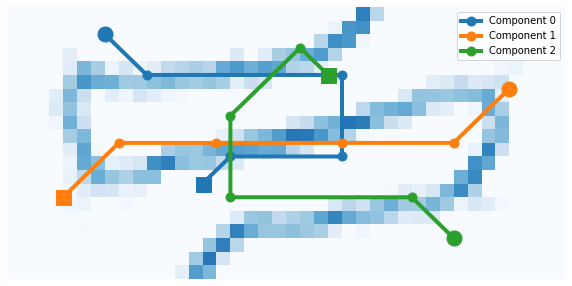

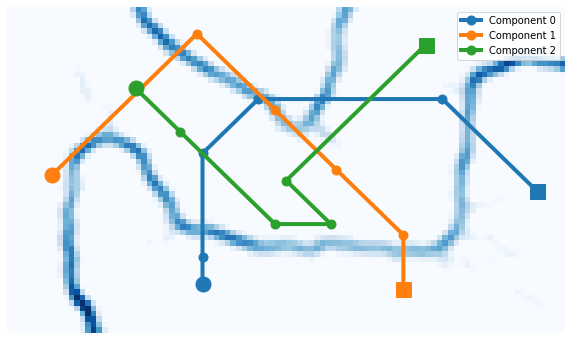

In [25]:
weights = SOMToolBoxParser("datasets/chainlink/chainlink_small.wgt.gz").read_weight_file()
metro_maps(weights, select=False, agg=False, snap=True, n_bins=6, _vmin=0.1,_vmax=0.45)

weights = SOMToolBoxParser("datasets/chainlink/chainlink_large.wgt.gz").read_weight_file()
metro_maps(weights, select=False, agg=False, snap=True, n_bins=6, _vmin=0.05,_vmax=0.25)

# References
[1] Neumayer, R., Mayer, R., Polzlbauer, G., & Rauber, A. (2007, August). The metro visualisation of component planes for self-organising maps. In 2007 International Joint Conference on Neural Networks (pp. 2788-2793). IEEE.
[2] https://github.com/yozoon/SOM-MetroMap (30.01.2022)